In [2]:
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
dataset = sg.datasets.Cora()
display(HTML(dataset.description))
G, node_subjects = dataset.load()

In [4]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


In [5]:
node_subjects.value_counts().to_frame()

,subject
Neural_Networks,818
Probabilistic_Methods,426
Genetic_Algorithms,418
Theory,351
Case_Based,298
Reinforcement_Learning,217
Rule_Learning,180


In [6]:
node_subjects.to_frame()

,subject
31336,Neural_Networks
1061127,Rule_Learning
1106406,Reinforcement_Learning
13195,Reinforcement_Learning
37879,Probabilistic_Methods
...,...
1128975,Genetic_Algorithms
1128977,Genetic_Algorithms
1128978,Genetic_Algorithms
117328,Case_Based


In [7]:
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=140, test_size=None, stratify=node_subjects
)
val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, train_size=500, test_size=None, stratify=test_subjects
)

In [8]:
train_subjects.value_counts().to_frame()

,subject
Neural_Networks,42
Probabilistic_Methods,22
Genetic_Algorithms,22
Theory,18
Case_Based,16
Reinforcement_Learning,11
Rule_Learning,9


In [9]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
val_targets = target_encoding.transform(val_subjects)
test_targets = target_encoding.transform(test_subjects)

In [10]:
generator = FullBatchNodeGenerator(G, method="gcn")

Using GCN (local pooling) filters...


In [11]:
train_gen = generator.flow(train_subjects.index, train_targets)

In [12]:
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=generator, dropout=0.5
)

In [13]:
x_inp, x_out = gcn.in_out_tensors()

x_out

<tf.Tensor 'gather_indices/Identity:0' shape=(1, None, 16) dtype=float32>

In [14]:

predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)



In [15]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.01),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

In [16]:
val_gen = generator.flow(val_subjects.index, val_targets)

In [17]:
from tensorflow.keras.callbacks import EarlyStopping

es_callback = EarlyStopping(monitor="val_acc", patience=50, restore_best_weights=True)

In [18]:
history = model.fit(
    train_gen,
    epochs=200,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback],
)

Epoch 1/200
1/1 - 0s - loss: 1.9518 - acc: 0.1786 - val_loss: 1.9297 - val_acc: 0.3320
Epoch 2/200
1/1 - 0s - loss: 1.9254 - acc: 0.2857 - val_loss: 1.9015 - val_acc: 0.4520
Epoch 3/200
1/1 - 0s - loss: 1.8885 - acc: 0.3857 - val_loss: 1.8589 - val_acc: 0.4680
Epoch 4/200
1/1 - 0s - loss: 1.8300 - acc: 0.5071 - val_loss: 1.8109 - val_acc: 0.4280
Epoch 5/200
1/1 - 0s - loss: 1.7672 - acc: 0.4857 - val_loss: 1.7577 - val_acc: 0.4220
Epoch 6/200
1/1 - 0s - loss: 1.7027 - acc: 0.4786 - val_loss: 1.6988 - val_acc: 0.4380
Epoch 7/200
1/1 - 0s - loss: 1.6042 - acc: 0.5286 - val_loss: 1.6339 - val_acc: 0.4620
Epoch 8/200
1/1 - 0s - loss: 1.5044 - acc: 0.5786 - val_loss: 1.5596 - val_acc: 0.5120
Epoch 9/200
1/1 - 0s - loss: 1.4287 - acc: 0.5929 - val_loss: 1.4815 - val_acc: 0.5400
Epoch 10/200
1/1 - 0s - loss: 1.3126 - acc: 0.6500 - val_loss: 1.4059 - val_acc: 0.5660
Epoch 11/200
1/1 - 0s - loss: 1.2339 - acc: 0.6643 - val_loss: 1.3337 - val_acc: 0.5740
Epoch 12/200
1/1 - 0s - loss: 1.1338 - ac

Epoch 95/200
1/1 - 0s - loss: 0.0240 - acc: 0.9929 - val_loss: 0.9111 - val_acc: 0.7780
Epoch 96/200
1/1 - 0s - loss: 0.0275 - acc: 1.0000 - val_loss: 0.9167 - val_acc: 0.7760
Epoch 97/200
1/1 - 0s - loss: 0.0130 - acc: 0.9929 - val_loss: 0.9242 - val_acc: 0.7800
Epoch 98/200
1/1 - 0s - loss: 0.0225 - acc: 1.0000 - val_loss: 0.9324 - val_acc: 0.7820
Epoch 99/200
1/1 - 0s - loss: 0.0207 - acc: 0.9929 - val_loss: 0.9405 - val_acc: 0.7820
Epoch 100/200
1/1 - 0s - loss: 0.0356 - acc: 0.9786 - val_loss: 0.9465 - val_acc: 0.7840
Epoch 101/200
1/1 - 0s - loss: 0.0281 - acc: 0.9929 - val_loss: 0.9526 - val_acc: 0.7820
Epoch 102/200
1/1 - 0s - loss: 0.0167 - acc: 1.0000 - val_loss: 0.9590 - val_acc: 0.7780
Epoch 103/200
1/1 - 0s - loss: 0.0679 - acc: 0.9714 - val_loss: 0.9682 - val_acc: 0.7780
Epoch 104/200
1/1 - 0s - loss: 0.0207 - acc: 0.9929 - val_loss: 0.9758 - val_acc: 0.7780
Epoch 105/200
1/1 - 0s - loss: 0.0309 - acc: 0.9929 - val_loss: 0.9815 - val_acc: 0.7700
Epoch 106/200
1/1 - 0s - l

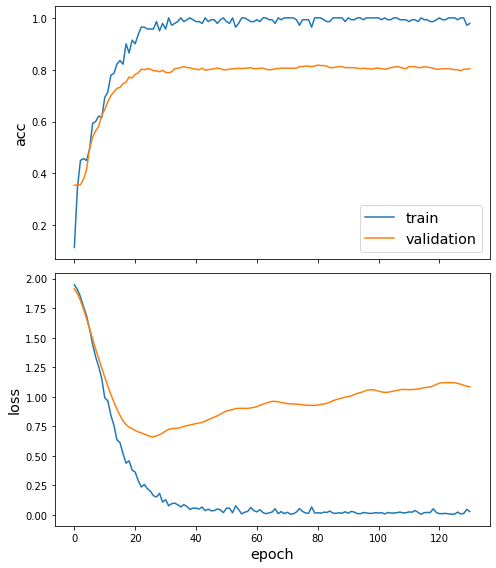

In [18]:
sg.utils.plot_history(history)

In [19]:
test_gen = generator.flow(test_subjects.index, test_targets)

In [20]:

test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))



1/1 [==============================] - 0s 0s/step - loss: 0.8545 - acc: 0.7877

Test Set Metrics:
	loss: 0.8545
	acc: 0.7877


In [21]:
all_nodes = node_subjects.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)

In [28]:
print(type(node_subjects))
node_subjects

<class 'pandas.core.series.Series'>


31336             Neural_Networks
1061127             Rule_Learning
1106406    Reinforcement_Learning
13195      Reinforcement_Learning
37879       Probabilistic_Methods
                    ...          
1128975        Genetic_Algorithms
1128977        Genetic_Algorithms
1128978        Genetic_Algorithms
117328                 Case_Based
24043             Neural_Networks
Name: subject, Length: 2708, dtype: object

In [30]:
node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())

print(node_predictions)

['Probabilistic_Methods' 'Theory' 'Reinforcement_Learning' ...
 'Genetic_Algorithms' 'Case_Based' 'Neural_Networks']


In [24]:

df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
df.head(20)

,Predicted,True
31336,Probabilistic_Methods,Neural_Networks
1061127,Theory,Rule_Learning
1106406,Reinforcement_Learning,Reinforcement_Learning
13195,Reinforcement_Learning,Reinforcement_Learning
37879,Probabilistic_Methods,Probabilistic_Methods
1126012,Probabilistic_Methods,Probabilistic_Methods
1107140,Theory,Theory
1102850,Theory,Neural_Networks
31349,Theory,Neural_Networks
1106418,Theory,Theory
